### Задание

In [20]:
import torch
import torch.nn as nn
torch.manual_seed(0)

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler 

In [22]:
import matplotlib.pyplot as plt

1. Повторите шаги 1-4 из предыдущего задания со следующими изменениями:

- ширину окна $k$ из задания 3 положите равной 4;
- размерность `X` на выходе: (размер выборки, ширина окна `k`, 1).

In [23]:
data = pd.read_csv('passengers.csv', index_col='date')
data.head()

,num_passengers
date,
1949-1-1,112
1949-2-1,118
1949-3-1,132
1949-4-1,129
1949-5-1,121


In [24]:
scaler = MinMaxScaler()
scaler.fit(data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [25]:
dataScaler = scaler.transform(data)

In [26]:
def toTorchTensor(data, k):
  x = []
  y = data[k:]
  for i in range(len(data)-k):
    x.append(data[i:k+i]) 
  res = pd.DataFrame(x)
  res['y'] = y
  return res

In [27]:
df = toTorchTensor(dataScaler.reshape(1,-1)[0], 4)
df.columns = ['x1','x2','x3','x4','y']
df.head()

,x1,x2,x3,x4,y
0,0.015444,0.027027,0.054054,0.048263,0.032819
1,0.027027,0.054054,0.048263,0.032819,0.059846
2,0.054054,0.048263,0.032819,0.059846,0.084942
3,0.048263,0.032819,0.059846,0.084942,0.084942
4,0.032819,0.059846,0.084942,0.084942,0.061776


In [28]:
ttX = torch.FloatTensor(df.iloc[:,0:4].values)
ttY = torch.FloatTensor(df['y'])

In [29]:
ttX = ttX.reshape(len(ttY), 1, 4)

In [30]:
xTrain, yTrain = ttX[:-36], ttY[:-36]
xTest, yTest = ttX[-36:], ttY[-36:]

2. Реализуйте сеть LSTM для решения задачи прогнозирования объемов пассажирских авиаперевозок. Воспользуйтесь шаблоном ниже:

- в `__init__` укажите два слоя: LSTM (`torch.nn.LSTM`) и полносвязный (`torch.nn.Linear`). Для слоя LSTM укажите параметры: `input_size=1`, размер скрытого вектора $h$ `hidden_size=hidden_size`, количество слоев `num_layers=1` и `batch_first=True`;
- слой LSTM вернет последнее скрытое состояние $h_t$, которое далее должно быть передано в полносвязный слой. Учитывая это, укажите нужную размерность входного и выходного векторов в полносвязном слое `torch.nn.Linear`;
- в методе `forward` задаются начальные состояния $h_0$ и ячейки памяти $c_0$, их размерности должны совпадать;
- после применения слоя LSTM переменная `h_out` будет хранить последнее скрытое состояние, которое затем необходимо преобразовать в вектор;
- после данного преобразования примените полносвязный слой и обучите полученную сеть на 2000 эпохах с шагом обучения 0.01 (функция потерь также MSE, оптимизатор &ndash; Adam).

In [31]:
class LSTM(nn.Module):

    def __init__(self, hidden_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear_layer = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, inputs):
        
        h_0 = torch.zeros(1, inputs.size(0), self.hidden_size)
        c_0 = torch.zeros(1, inputs.size(0), self.hidden_size)

        output_features, (h_out, _) = self.lstm(inputs, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        output = self.linear_layer(h_out)
        return output

In [32]:
model = LSTM(7)

In [33]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [34]:
epochs = 2000
totalStep = len(yTrain)

for epoch in range(epochs):
  for i, (x, y) in enumerate(zip(xTrain, yTrain)):
    outputs = model(x.reshape(1, 4, 1))
    loss = criterion(outputs, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print ('Epoch [{}/{}], Spep [{}/{}], Loss: {:.4f}'
                .format(epoch+1, epochs, i+1, totalStep, loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch [1952/2000], Spep [97/104], Loss: 0.0002
Epoch [1952/2000], Spep [98/104], Loss: 0.0005
Epoch [1952/2000], Spep [99/104], Loss: 0.0000
Epoch [1952/2000], Spep [100/104], Loss: 0.0000
Epoch [1952/2000], Spep [101/104], Loss: 0.0003
Epoch [1952/2000], Spep [102/104], Loss: 0.0001
Epoch [1952/2000], Spep [103/104], Loss: 0.0001
Epoch [1952/2000], Spep [104/104], Loss: 0.0000
Epoch [1953/2000], Spep [1/104], Loss: 0.0087
Epoch [1953/2000], Spep [2/104], Loss: 0.0026
Epoch [1953/2000], Spep [3/104], Loss: 0.0035
Epoch [1953/2000], Spep [4/104], Loss: 0.0044
Epoch [1953/2000], Spep [5/104], Loss: 0.0053
Epoch [1953/2000], Spep [6/104], Loss: 0.0045
Epoch [1953/2000], Spep [7/104], Loss: 0.0031
Epoch [1953/2000], Spep [8/104], Loss: 0.0000
Epoch [1953/2000], Spep [9/104], Loss: 0.0010
Epoch [1953/2000], Spep [10/104], Loss: 0.0010
Epoch [1953/2000], Spep [11/104], Loss: 0.0013
Epoch [1953/2000], Spep [12/104], Loss: 0.0

3. Повторите шаги 7-8 из предыдущего задания.

In [41]:
xTest[0]

tensor([[0.5792, 0.4691, 0.3880, 0.4479]])

In [68]:
model.eval()
with torch.no_grad():
  prog = []
  for i in xTest:
    prog.append(model(i.reshape(1,4,1)))
prog = torch.FloatTensor(prog)

In [69]:
npOutputs = prog.data.numpy()

In [70]:
pred = scaler.inverse_transform(prog.reshape(-1, 1))

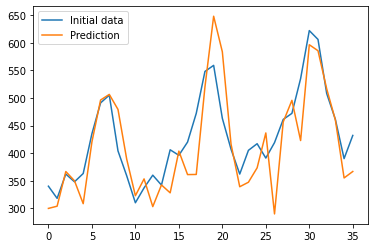

In [72]:
plt.plot(scaler.inverse_transform(yTest.reshape(-1, 1)), label='Initial data')
plt.plot(pred, label='Prediction')
plt.legend()
plt.show()

4. \* Попробуйте улучшить качество предсказаний (и CNN, и LSTM), меняя следующие параметры:

- ширину окна $k$;
- ширину окна сверточного слоя и слоя субдискретизации;
- количество слоев;
- количество нейронов скрытого слоя и т.д.